In [23]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

## Election Results

Election results from Nevada Secretary of State (https://www.nvsos.gov/sos/elections/election-information/precinct-level-results).

## Shape Files
Precinct shapefiles from the U.S. Census Bureau's 2020 Redistricting Data Program, except the following counties use shapefiles sourced from the respective county governments instead: Clark, Douglas, Elko, Humboldt, Lincoln, Lyon, Washoe. Precinct boundaries in Churchill, Eureka, Nye were aligned with county maps.

## Processing
President-only ballots were reported countywide for Carson City, Churchill, Clark, Douglas, Esmeralda, Eureka, Humboldt, Lander, Lyon, Nye, Washoe, White Pine. These were distributed by candidate to precincts based on the precinct-level reported vote.

## Races

 - G20PREDBID - Joseph R. Biden (Democratic Party)
 - G20PRERTRU - Donald J. Trump (Republican Party)
 - G20PRELJOR - Jo Jorgensen (Libertarian Party)
 - G20PREIBLA - Dan Blankenship (Independent American Party)
 - G20PREONON - None of These Candidates



In [24]:
vest_shp = gp.read_file("./raw-from-source/nv_2020/nv_2020.shp")
shp1 = vest_shp.iloc[: , :-1]


In [25]:
 vest_shp.shape

(2094, 11)

In [26]:
vest_shp.head()

,STATEFP,COUNTYFP,COUNTY,VTDST,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREIBLA,G20PREONON,geometry
0,32,001,Churchill,000014,CHURCHILL PRECINCT 14,100,500,12,1,8,"POLYGON Z ((-119.06227 39.34643 0.00000, -119...."
1,32,001,Churchill,000019,CHURCHILL PRECINCT 19,117,504,13,1,6,"POLYGON Z ((-119.11763 39.50918 0.00000, -119...."
2,32,009,Esmeralda,000001,ESMERALDA GOLDFIELD PRECINCT 1,36,179,4,1,3,"POLYGON Z ((-117.43051 37.78696 0.00000, -117...."
3,32,009,Esmeralda,000002,ESMERALDA SILVER PEAK PRECINCT 2,4,42,0,0,1,"POLYGON Z ((-117.87888 37.91707 0.00000, -117...."
4,32,009,Esmeralda,000003,ESMERALDA FISH LAKE VALLEY PRECINCT 3,30,165,2,0,2,"POLYGON Z ((-118.42300 37.89637 0.00000, -118...."


<AxesSubplot:>

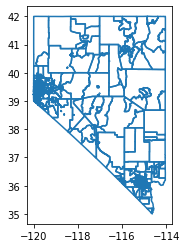

In [27]:
vest_shp.boundary.plot()

<AxesSubplot:>

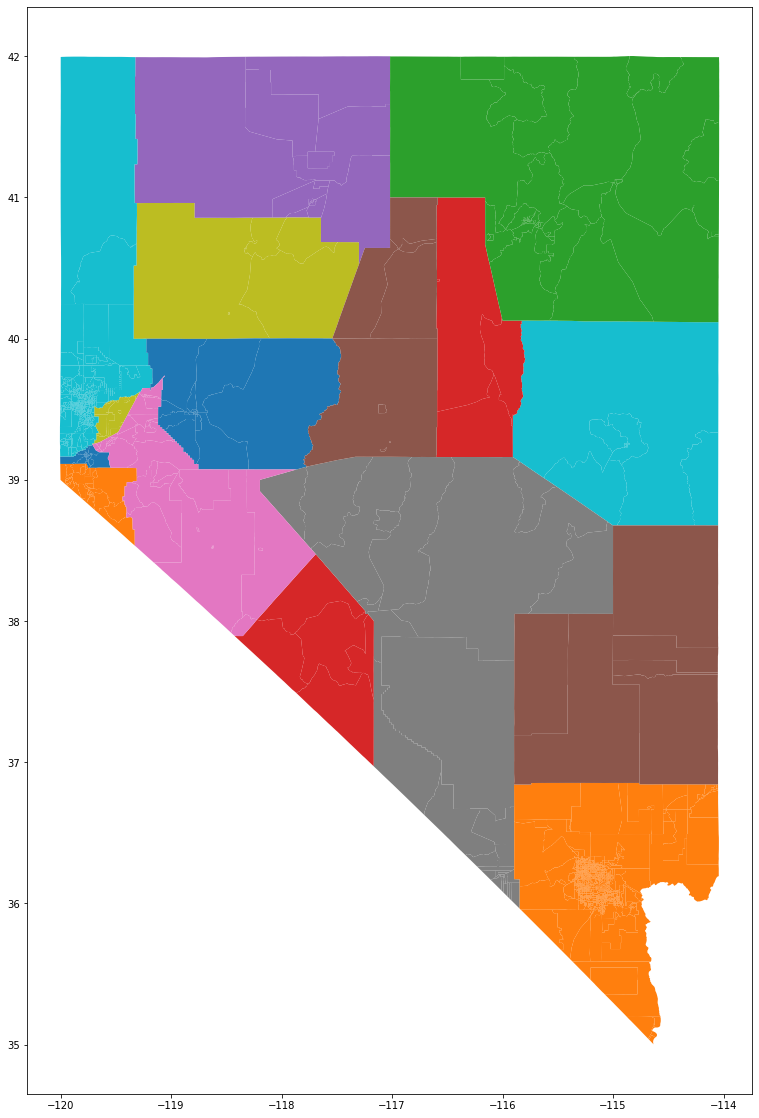

In [28]:
vest_shp.plot(column='COUNTY', figsize=(20,20))

In [29]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY', 'VTDST', 'NAME', 'G20PREDBID',
       'G20PRERTRU', 'G20PRELJOR', 'G20PREIBLA', 'G20PREONON', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

In [30]:
nv_20 = pd.read_csv("./raw-from-source/results/2020 General Election Precinct-Level Results.csv", index_col=False)

In [31]:
nv_20.head()

,2020 Statewide General Election Results,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Note: In cases where the cumulative turnout fo...,NaN,NaN,NaN,NaN
1,Jurisdiction,Precinct,Contest,Selection,Votes
2,Carson City,101,"Board of Supervisors, Ward 2","WHITE, MAURICE ""MO""",532
3,Carson City,101,"Board of Supervisors, Ward 2","WILKE-MCCULLOCH, STACIE",467
4,Carson City,101,"Court Of Appeals Judge, Dept. 3","BULLA, BONNIE",402


In [32]:
nv_20.shape

(182872, 5)

In [33]:
nv_20.columns = nv_20.iloc[1]
nv_20 = nv_20[2:]

nv_20.head()

1,Jurisdiction,Precinct,Contest,Selection,Votes
2,Carson City,101,"Board of Supervisors, Ward 2","WHITE, MAURICE ""MO""",532
3,Carson City,101,"Board of Supervisors, Ward 2","WILKE-MCCULLOCH, STACIE",467
4,Carson City,101,"Court Of Appeals Judge, Dept. 3","BULLA, BONNIE",402
5,Carson City,101,"Court Of Appeals Judge, Dept. 3","BUSH, SUSAN",367
6,Carson City,101,"Court Of Appeals Judge, Dept. 3",None Of These Candidates,230


## Clean Up the Elections Results

In [34]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_20 = nv_20.loc[(nv_20['Contest']== 'President and Vice President of the United States')]
filtered_20.reset_index(drop=True, inplace = True)
#filtered_20.to_csv('filtered.csv')
nv_unq = nv_20['Contest'].value_counts()
nv_unq

President and Vice President of the United States    10060
Court Of Appeals Judge, Dept. 3                       5976
Supreme Court Justice, Seat D                         5976
STATE QUESTION NO. 3                                  3984
STATE QUESTION NO. 1                                  3984
                                                     ...  
CITY OF LOVELOCK MAYOR                                   4
SCHOOL DISTRICT TRUSTEE, SEAT 1B                         4
EUREKA COUNTY TELEVISION DISTRICT SEAT 4B                4
EUREKA COUNTY TELEVISION DISTRICT SEAT 4E                4
Crescent Valley Town Advisory Board                      4
Name: Contest, Length: 264, dtype: int64

In [35]:
filtered_20['Votes'] = filtered_20['Votes'].replace(to_replace=r'\*', value='0', regex=True)

<ipython-input-35-531676a3ee65>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_20['Votes'] = filtered_20['Votes'].replace(to_replace=r'\*', value='0', regex=True)


In [36]:
filtered_20['Votes'] = filtered_20['Votes'].astype(int)
#filtered_20.to_csv('./filtered1.csv')
filtered_20
filtered_20.dtypes

<ipython-input-36-e9e305b8b342>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_20['Votes'] = filtered_20['Votes'].astype(int)


1
Jurisdiction    object
Precinct        object
Contest         object
Selection       object
Votes            int32
dtype: object

In [37]:
#pivoting based on cand_name and precinct vote totals
pivot_df = pd.pivot_table(filtered_20, index = ['Precinct','Jurisdiction'], columns = 'Selection', values='Votes')

#dropping and renaming columns to match VEST

pivot_df = pivot_df.rename(columns={'BIDEN, JOSEPH R.':'G20PREDBID','TRUMP, DONALD J.':'G20PRERTRU','JORGENSEN, JO':'G20PRELJOR','BLANKENSHIP, DON':'G20PREIBLA','None Of These Candidates':'G20PREONON'})
pivot_df = pivot_df[['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREIBLA','G20PREONON']]
pivot_df.reset_index(inplace=True)
print(pivot_df)

Selection                  Precinct Jurisdiction  G20PRERTRU  G20PREDBID  \
0                    01-Centerville      Douglas         648         213   
1                   02-Fish Springs      Douglas         950         406   
2                   03-Gardnerville      Douglas         650         461   
3          04-Carson Valley Estates      Douglas         499         301   
4                          05-Genoa      Douglas         614         288   
...                             ...          ...         ...         ...   
2007                     TONOPAH 14          Nye         753         188   
2008                     TONOPAH 15          Nye          27          15   
2009            West Mason Valley 1         Lyon         501         242   
2010            West Mason Valley 2         Lyon         346          90   
2011            West Mason Valley 3         Lyon          28          15   

Selection  G20PRELJOR  G20PREIBLA  G20PREONON  
0                   5           2      

In [38]:
#uploading national FIPS codes to apply back to file
FIPS = pd.read_csv('./raw-from-source/US_FIPS_Codes.csv')
FIPS = FIPS[FIPS['State'] == 'Nevada']
FIPS1 = FIPS.drop(['State','FIPS State'],axis=1)

#adding leading zeroes to FIPS data
FIPS1['FIPS County'] = FIPS1['FIPS County'].apply(lambda x:'{0:0>3}'.format(x))
FIPS1['Jurisdiction'] = FIPS1['County Name']
FIPS1.reset_index(inplace=True)
FIPS1 = FIPS1.drop(['index'],axis=1)
FIPS1 = FIPS1.iloc[: , 1:]
print(FIPS1)


   FIPS County Jurisdiction
0          001    Churchill
1          003        Clark
2          005      Douglas
3          007         Elko
4          009    Esmeralda
5          011       Eureka
6          013     Humboldt
7          015       Lander
8          017      Lincoln
9          019         Lyon
10         021      Mineral
11         023          Nye
12         027     Pershing
13         029       Storey
14         031       Washoe
15         033   White Pine
16         510  Carson City


In [39]:

pivot_df['Precinct'] = pivot_df['Precinct'].str.lower()
pivot_df = pivot_df.merge(FIPS1, how='left', on='Jurisdiction')
pivot_df

,Precinct,Jurisdiction,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREIBLA,G20PREONON,FIPS County
0,01-centerville,Douglas,648,213,5,2,6,005
1,02-fish springs,Douglas,950,406,16,1,18,005
2,03-gardnerville,Douglas,650,461,13,2,16,005
3,04-carson valley estates,Douglas,499,301,22,3,11,005
4,05-genoa,Douglas,614,288,7,2,12,005
...,...,...,...,...,...,...,...,...
2007,tonopah 14,Nye,753,188,14,2,10,023
2008,tonopah 15,Nye,27,15,0,0,3,023
2009,west mason valley 1,Lyon,501,242,3,3,12,019
2010,west mason valley 2,Lyon,346,90,2,2,5,019


In [40]:
#remove non-alphanumeric characters
def alphanum(element):
    
    return "".join(filter(str.isalnum, element))
pivot_df.loc[:,'NAME'] = [alphanum(x) for x in pivot_df['Precinct']]
pivot_df['unq_id'] = pivot_df["Precinct"] + " " + pivot_df["FIPS County"]
pivot_df

,Precinct,Jurisdiction,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREIBLA,G20PREONON,FIPS County,NAME,unq_id
0,01-centerville,Douglas,648,213,5,2,6,005,01centerville,01-centerville 005
1,02-fish springs,Douglas,950,406,16,1,18,005,02fishsprings,02-fish springs 005
2,03-gardnerville,Douglas,650,461,13,2,16,005,03gardnerville,03-gardnerville 005
3,04-carson valley estates,Douglas,499,301,22,3,11,005,04carsonvalleyestates,04-carson valley estates 005
4,05-genoa,Douglas,614,288,7,2,12,005,05genoa,05-genoa 005
...,...,...,...,...,...,...,...,...,...,...
2007,tonopah 14,Nye,753,188,14,2,10,023,tonopah14,tonopah 14 023
2008,tonopah 15,Nye,27,15,0,0,3,023,tonopah15,tonopah 15 023
2009,west mason valley 1,Lyon,501,242,3,3,12,019,westmasonvalley1,west mason valley 1 019
2010,west mason valley 2,Lyon,346,90,2,2,5,019,westmasonvalley2,west mason valley 2 019


In [42]:
vest_shp = vest_shp.iloc[:,:-1]
vest_shp['NAME'] = vest_shp['NAME'].str.lower()
vest_shp['NAME'] = vest_shp['NAME'].astype(str)
vest_shp.loc[:,'NAME'] = [alphanum(x) for x in vest_shp['NAME']]
vest_shp['unq_id'] = vest_shp["NAME"] + " " + vest_shp["COUNTYFP"]
vest_shp

,STATEFP,COUNTYFP,COUNTY,VTDST,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREIBLA,unq_id
0,32,001,Churchill,000014,churchillprecinct14,100,500,12,1,churchillprecinct14 001
1,32,001,Churchill,000019,churchillprecinct19,117,504,13,1,churchillprecinct19 001
2,32,009,Esmeralda,000001,esmeraldagoldfieldprecinct1,36,179,4,1,esmeraldagoldfieldprecinct1 009
3,32,009,Esmeralda,000002,esmeraldasilverpeakprecinct2,4,42,0,0,esmeraldasilverpeakprecinct2 009
4,32,009,Esmeralda,000003,esmeraldafishlakevalleyprecinct3,30,165,2,0,esmeraldafishlakevalleyprecinct3 009
...,...,...,...,...,...,...,...,...,...,...
2089,32,019,Lyon,000002,eastmasonvalley2,158,530,6,5,eastmasonvalley2 019
2090,32,019,Lyon,000001,eastmasonvalley1,169,480,8,4,eastmasonvalley1 019
2091,32,019,Lyon,000006,spraggplummer,319,968,12,4,spraggplummer 019
2092,32,019,Lyon,000008,smithvalley2,68,269,5,0,smithvalley2 019


In [43]:

pivot_df.rename(columns = {'Precinct':'NAME'}, inplace = True)
join_1 = pd.merge(pivot_df, vest_shp, how="outer",on='unq_id', indicator = True, validate="1:1")
join_1["_merge"].value_counts()

both          1148
right_only     946
left_only      864
Name: _merge, dtype: int64

In [47]:
source_to_vest = {"precinct 01 001":"churchillprecinct01 001",
"precinct 02 001":"churchillprecinct02 001",
"precinct 03 001":"churchillprecinct03 001",
"precinct 04 001":"churchillprecinct04 001",
"precinct 05 001":"churchillprecinct05 001",
"precinct 06 001":"churchillprecinct06 001",
"precinct 07 001":"churchillprecinct07 001",
"precinct 08 001":"churchillprecinct08 001",
"precinct 09 001":"churchillprecinct09 001",
"precinct 10 001":"churchillprecinct10 001",
"precinct 11 001":"churchillprecinct11 001",
"precinct 12 001":"churchillprecinct12 001",
"precinct 13 001":"churchillprecinct13 001",
"precinct 14 001":"churchillprecinct14 001",
"precinct 15 001":"churchillprecinct15 001",
"precinct 16 001":"churchillprecinct16 001",
"precinct 17 001":"churchillprecinct17 001",
"precinct 18 001":"churchillprecinct18 001",
"precinct 19 001":"churchillprecinct19 001",
"01-centerville 005":"precinct1centerville 005",
"02-fish springs 005":"precinct2fishsprings 005",
"03-gardnerville 005":"precinct3gardnerville 005",
"04-carson valley estates 005":"precinct4carsonvalleyestates 005",
"05-genoa 005":"precinct5genoa 005",
"06-jacks valley 005":"precinct6jacksvalley 005",
"07-minden 005":"precinct7minden 005",
"08-ranchos i 005":"precinct8ranchosi 005",
"09-ranchos ii 005":"precinct9ranchosii 005",
"10-tre 005":"precinct10topazranchestates 005",
"11-johnson lane 005":"precinct11johnsonlane 005",
"12-dresslerville 005":"precinct12dresslerville 005",
"13-indian hills - west 005":"precinct13indianhillswest 005",
"14-pinenut 005":"precinct14pinenut 005",
"15-valley 005":"precinct15valley 005",
"16-mottsville 005":"precinct16mottsville 005",
"17-ruhenstroth 005":"precinct17ruhenstroth 005",
"18-ranchos iii-2 005":"precinct18ranchosiii 005",
"19-ranchos iv 005":"precinct19ranchosiv 005",
"20-birch/ranchos 005":"precinct20birchranchos 005",
"21-wildhorse 005":"precinct21wildhorse 005",
"22-saratoga 005":"precinct22saratoga 005",
"23-indian hills - east 005":"precinct23indianhillseast 005",
"24-topaz lake 005":"precinct24topazlake 005",
"25-pleasantview 005":"precinct25pleasantview 005",
"26-westwood 005":"precinct26westwood 005",
"27-winhaven 005":"precinct27winhaven 005",
"28-orchard road 005":"precinct28orchardroad 005",
"29-autumn hils 005":"precinct29autumnhills 005",
"30-east fork 005":"precinct30eastfork 005",
"31-chichester 005":"precinct31chichester 005",
"32-east valley 005":"precinct32eastvalley 005",
"33-hot springs 005":"precinct33hotsprings 005",
"34-sunridge 005":"precinct34sunridge 005",
"35-glenbrook 005":"precinct35glenbrook 005",
"36-skyland 005":"precinct36skyland 005",
"37-zephyr cove 005":"precinct37zephyrcove 005",
"38-round hill 005":"precinct38roundhill 005",
"39-edgewood 005":"precinct39edgewood 005",
"40-kingsbury 005":"precinct40kingsbury 005",
"41-daggett 005":"precinct41daggett 005",
"precinct 88 005":"votingdistrictsnotdefined 005",
"precinct 1 007":"elkovtd1elkocity1 007",
"precinct 10 007":"elkovtd10elkocity10 007",
"precinct 11 007":"elkovtd11elkocity11 007",
"precinct 12 007":"elkovtd12elkoruralnorth 007",
"precinct 13 007":"elkovtd13elkoruralsouth 007",
"precinct 14 007":"elkovtd14elkocity14 007",
"precinct 15 007":"elkovtd15carlin2 007",
"precinct 16 007":"elkovtd16carlin1 007",
"precinct 17 007":"elkovtd17carlinrural 007",
"precinct 18 007":"elkovtd18wells1 007",
"precinct 19 007":"elkovtd19wells2 007",
"precinct 2 007":"elkovtd2elkocity2 007",
"precinct 20 007":"elkovtd20wendovernorth 007",
"precinct 21 007":"elkovtd21wendoversouth 007",
"precinct 22 007":"elkovtd22springcreeksouth 007",
"precinct 23 007":"elkovtd23springcreek 007",
"precinct 24 007":"elkovtd24springcreekmobile1 007",
"precinct 25 007":"elkovtd25springcreekmobile2 007",
"precinct 26 007":"elkovtd26lamoille 007",
"precinct 27 007":"elkovtd27moundvalley 007",
"precinct 28 007":"elkovtd28jackcreek 007",
"precinct 29 007":"elkovtd29owyhee 007",
"precinct 3 007":"elkovtd3elkocity3 007",
"precinct 30 007":"elkovtd30mountaincity 007",
"precinct 31 007":"elkovtd31northfork 007",
"precinct 32 007":"elkovtd32ryndon 007",
"precinct 33 007":"elkovtd33marysriver 007",
"precinct 34 007":"elkovtd34starrvalley 007",
"precinct 35 007":"elkovtd35rubyvalley 007",
"precinct 36 007":"elkovtd36clovervalley 007",
"precinct 37 007":"elkovtd37oasiswinecup 007",
"precinct 38 007":"elkovtd38jackpot 007",
"precinct 39 007":"elkovtd39montello 007",
"precinct 4 007":"elkovtd4elkocity4 007",
"precinct 40 007":"elkovtd40springcreek 007",
"precinct 41 007":"elkovtd41springcreeknorth 007",
"precinct 5 007":"elkovtd5elkocity5 007",
"precinct 6 007":"elkovtd6elkocity6 007",
"precinct 7 007":"elkovtd7elkocity7 007",
"precinct 8 007":"elkovtd8elkocity8 007",
"precinct 9 007":"elkovtd9elkocity9 007",
"precinct 1 009":"esmeraldagoldfieldprecinct1 009",
"precinct 2 009":"esmeraldasilverpeakprecinct2 009",
"precinct 3 009":"esmeraldafishlakevalleyprecinct3 009",
"precinct 4 009":"esmeraldagoldpointlidaprecinct4 009",
"precinct 5 009":"esmeraldalambertucciprecinct5 009",
"precinct 1 011":"precinct1 011",
"precinct 2 011":"precinct2 011",
"precinct 3 011":"precinct3 011",
"precinct 4 011":"precinct4crescentvalleytown 011",
"precinct 1 013":"humboldtwinnemuccaprecinct1 013",
"precinct 10 013":"humboldtprecinct10 013",
"precinct 11 013":"humboldtprecinct11 013",
"precinct 12 013":"humboldtprecinct12 013",
"precinct 13 013":"humboldtprecinct13 013",
"precinct 14 013":"humboldtprecinct14 013",
"precinct 15 013":"humboldtprecinct15 013",
"precinct 2 013":"humboldtwinnemuccaprecinct2 013",
"precinct 3 013":"humboldtwinnemuccaprecinct3 013",
"precinct 4 013":"humboldtwinnemuccaprecinct4 013",
"precinct 5 013":"humboldtwinnemuccaprecinct5 013",
"precinct 6 013":"humboldtprecinct6 013",
"precinct 7 013":"humboldtprecinct7 013",
"precinct 8 013":"humboldtprecinct8 013",
"precinct 9 013":"humboldtprecinct9 013",
"argenta 01 015":"precinctno1argenta 015",
"argenta 02 015":"precinctno2argenta 015",
"argenta 03 015":"precinctno3argenta 015",
"argenta 04 015":"precinctno4argenta 015",
"argenta 05 015":"precinctno5argenta 015",
"austin 07 015":"precinctno7austin 015",
"gillman springs ranch 08 015":"precinctno8gilmanspringsranch 015",
"kingston 09 015":"precinctno9kingston 015",
"southern lander county 06 015":"precinctno6southernlandercounty 015",
"1 - alamo 017":"precinct1alamo 017",
"233 - caliente north 017":"precinct233calientenorth 017",
"236 - caliente south 017":"precinct236calientesouth 017",
"3 - panaca 017":"precinct3panaca 017",
"4 - pioche 017":"precinct4pioche 017",
"5 - rachel 017":"precinct5rachel 017",
"east mason valley 1 019":"eastmasonvalley1 019",
"east mason valley 2 019":"eastmasonvalley2 019",
"fernley 1 019":"fernley1 019",
"fernley 10 019":"fernley10 019",
"fernley 11 019":"fernley11 019",
"fernley 12 019":"fernley12 019",
"fernley 13 019":"fernley13 019",
"fernley 14 019":"fernley14 019",
"fernley 2 019":"fernley2 019",
"fernley 3 019":"fernley3 019",
"fernley 4 019":"fernley4 019",
"fernley 5 019":"fernley5 019",
"fernley 6 019":"fernley6 019",
"fernley 7 019":"fernley7 019",
"fernley 8 019":"fernley8 019",
"fernley 9 019":"fernley9 019",
"mound house 1 019":"moundhouse1 019",
"mound house 2 019":"moundhouse2 019",
"north dayton 1 019":"northdayton1 019",
"north dayton 2 019":"northdayton2 019",
"north dayton 3 019":"northdayton3 019",
"north dayton 4 019":"northdayton4 019",
"north dayton 5 019":"northdayton5 019",
"silver city 019":"silvercity 019",
"silver springs 1 019":"silversprings1 019",
"silver springs 2 019":"silversprings2 019",
"silver springs 3 019":"silversprings3 019",
"silver springs 4 019":"silversprings4 019",
"smith valley 1 019":"smithvalley1 019",
"smith valley 2 019":"smithvalley2 019",
"south dayton 1 019":"southdayton1 019",
"south dayton 2 019":"southdayton2 019",
"south dayton 3 019":"southdayton3 019",
"south dayton 4 019":"southdayton4 019",
"spragg-plummer 019":"spraggplummer 019",
"stagecoach 1 019":"stagecoach1 019",
"stagecoach 2 019":"stagecoach2 019",
"west mason valley 1 019":"westmasonvalley1 019",
"west mason valley 2 019":"westmasonvalley2 019",
"west mason valley 3 019":"westmasonvalley3 019",
"precinct 1 021":"hawthorneprecinct1 021",
"precinct 10 021":"montgomerypassprecinct10 021",
"precinct 11 021":"schurzprecinct11 021",
"precinct 12 021":"walkerlakeprecinct12 021",
"precinct 2 021":"hawthorneprecinct2 021",
"precinct 3 021":"hawthorneprecinct3 021",
"precinct 4 021":"hawthorneprecinct4 021",
"precinct 5 021":"hawthorneprecinct5 021",
"precinct 6 021":"hawthorneprecinct6 021",
"precinct 7 021":"hawthorneruralprecinct7 021",
"precinct 8 021":"luningprecinct8 021",
"precinct 9 021":"minaprecinct9 021",
"amargosa vly 06 023":"amargosavalley06 023",
"beatty 01 023":"beatty01 023",
"currant 02 023":"currantcreek02 023",
"duckwater 03 023":"duckwater03 023",
"forty bar 18 023":"fortybar18 023",
"gabbs 04 023":"gabbs04 023",
"ione 05 023":"ione05 023",
"manhattan 07 023":"manhattan07 023",
"mercury 08 023":"mercury08 023",
"pahrump 09 023":"pahrump09 023",
"pahrump 10 023":"pahrump10 023",
"pahrump 11 023":"pahrump11 023",
"pahrump 16 023":"pahrump16 023",
"pahrump 17 023":"pahrump17 023",
"pahrump 19 023":"pahrump19 023",
"pahrump 20 023":"pahrump20 023",
"pahrump 21 023":"pahrump21 023",
"pahrump 22 023":"pahrump22 023",
"pahrump 23 023":"pahrump23 023",
"pahrump 24 023":"pahrump24 023",
"pahrump 25 023":"pahrump25 023",
"pahrump 26 023":"pahrump26 023",
"pahrump 27 023":"pahrump27 023",
"pahrump 28 023":"pahrump28 023",
"pahrump 29 023":"pahrump29 023",
"pahrump 30 023":"pahrump30 023",
"pahrump 31 023":"pahrump31 023",
"pahrump 32 023":"pahrump32 023",
"round mtn 12 023":"roundmountain12 023",
"smoky valley 35 023":"smokyvalley35 023",
"sunnyside 13 023":"sunnyside13 023",
"tonopah 14 023":"tonopah14 023",
"tonopah 15 023":"tonopah15 023",
"precinct 1 027":"precinct1 027",
"precinct 3 027":"precinct3 027",
"precinct 4 027":"precinct4 027",
"precinct 5 027":"precinct5imlay 027",
"precinct 6 027":"precinct6 027",
"precinct 7 027":"precinct7 027",
"precinct 1 029":"precinct1 029",
"precinct 10 029":"precinct10 029",
"precinct 11 029":"precinct11 029",
"precinct 12 029":"precinct12 029",
"precinct 13 029":"precinct13 029",
"precinct 14 029":"precinct14 029",
"precinct 15 029":"precinct15 029",
"precinct 2 029":"precinct2 029",
"precinct 3 029":"precinct3 029",
"precinct 4 029":"precinct4 029",
"precinct 5 029":"precinct5 029",
"precinct 6 029":"precinct6 029",
"precinct 7 029":"precinct7 029",
"precinct 8 029":"precinct8 029",
"precinct 9 029":"precinct9 029",
"ger-wads 7412 031":"7412 031",
"ger-wads 7521 (mp) 031":"7521 031",
"ger-wads 7522 (mp) 031":"7522 031",
"ger-wads 7531 (mp) 031":"7531 031",
"ger-wads 7581 031":"7581 031",
"ger-wads 7589 031":"7589 031",
"ger-wads 9408 (mp) 031":"9408 031",
"ger-wads 9557 (mp) 031":"9557 031",
"incline village 8104 031":"8104 031",
"incline village 8105 031":"8105 031",
"incline village 8106 031":"8106 031",
"incline village 8107 031":"8107 031",
"incline village 8108 031":"8108 031",
"incline village 8109 031":"8109 031",
"incline village 8110 031":"8110 031",
"incline village 8111 031":"8111 031",
"incline village 8116 031":"8116 031",
"incline village 8117 031":"8117 031",
"incline village 8125 031":"8125 031",
"incline village 8126(mp) 031":"8126 031",
"incline village 9101(mp) 031":"9101 031",
"incline village 9102(mp) 031":"9102 031",
"incline village 9106(mp) 031":"9106 031",
"incline village 9116(mp) 031":"9116 031",
"incline village 9121(mp) 031":"9121 031",
"incline village 9251(mp) 031":"9251 031",
"reno-verdi  9543 (mp) 031":"9543 031",
"reno-verdi 1000 031":"1000 031",
"reno-verdi 1002 031":"1002 031",
"reno-verdi 1003 031":"1003 031",
"reno-verdi 1005 (mp) 031":"1005 031",
"reno-verdi 1006 031":"1006 031",
"reno-verdi 1007 031":"1007 031",
"reno-verdi 1008 031":"1008 031",
"reno-verdi 1010 031":"1010 031",
"reno-verdi 1011 031":"1011 031",
"reno-verdi 1012 031":"1012 031",
"reno-verdi 1014 031":"1014 031",
"reno-verdi 1015 031":"1015 031",
"reno-verdi 1016 031":"1016 031",
"reno-verdi 1018 031":"1018 031",
"reno-verdi 1020 031":"1020 031",
"reno-verdi 1022 031":"1022 031",
"reno-verdi 1023 031":"1023 031",
"reno-verdi 1024 031":"1024 031",
"reno-verdi 1026 031":"1026 031",
"reno-verdi 1027 031":"1027 031",
"reno-verdi 1029 031":"1029 031",
"reno-verdi 1031 031":"1031 031",
"reno-verdi 1032 031":"1032 031",
"reno-verdi 1033 031":"1033 031",
"reno-verdi 1035 031":"1035 031",
"reno-verdi 1036 031":"1036 031",
"reno-verdi 1038 031":"1038 031",
"reno-verdi 1039 031":"1039 031",
"reno-verdi 1040 031":"1040 031",
"reno-verdi 1043 031":"1043 031",
"reno-verdi 1044 031":"1044 031",
"reno-verdi 1045 031":"1045 031",
"reno-verdi 1046 031":"1046 031",
"reno-verdi 1047 031":"1047 031",
"reno-verdi 1050 (mp) 031":"1050 031",
"reno-verdi 1051 031":"1051 031",
"reno-verdi 1053 031":"1053 031",
"reno-verdi 1055 031":"1055 031",
"reno-verdi 1056 031":"1056 031",
"reno-verdi 1057 031":"1057 031",
"reno-verdi 1058 031":"1058 031",
"reno-verdi 1059 (mp) 031":"1059 031",
"reno-verdi 1061 (mp) 031":"1061 031",
"reno-verdi 2000 031":"2000 031",
"reno-verdi 2002 (mp) 031":"2002 031",
"reno-verdi 2004 031":"2004 031",
"reno-verdi 2006 031":"2006 031",
"reno-verdi 2007 031":"2007 031",
"reno-verdi 2009 031":"2009 031",
"reno-verdi 2010 031":"2010 031",
"reno-verdi 2013 031":"2013 031",
"reno-verdi 2016 031":"2016 031",
"reno-verdi 2017 031":"2017 031",
"reno-verdi 2018 031":"2018 031",
"reno-verdi 2019 031":"2019 031",
"reno-verdi 2020 031":"2020 031",
"reno-verdi 2021 031":"2021 031",
"reno-verdi 2022 031":"2022 031",
"reno-verdi 2023 031":"2023 031",
"reno-verdi 2025 031":"2025 031",
"reno-verdi 2026 031":"2026 031",
"reno-verdi 2027 031":"2027 031",
"reno-verdi 2028 031":"2028 031",
"reno-verdi 2029 031":"2029 031",
"reno-verdi 2030 031":"2030 031",
"reno-verdi 2031 031":"2031 031",
"reno-verdi 2032 031":"2032 031",
"reno-verdi 2033 031":"2033 031",
"reno-verdi 2034 031":"2034 031",
"reno-verdi 2035 031":"2035 031",
"reno-verdi 2036 031":"2036 031",
"reno-verdi 2037 031":"2037 031",
"reno-verdi 2039 031":"2039 031",
"reno-verdi 2040 031":"2040 031",
"reno-verdi 2041 031":"2041 031",
"reno-verdi 2042 031":"2042 031",
"reno-verdi 2043 031":"2043 031",
"reno-verdi 2047 031":"2047 031",
"reno-verdi 2048 (mp) 031":"2048 031",
"reno-verdi 2049 031":"2049 031",
"reno-verdi 2050 031":"2050 031",
"reno-verdi 2051 (mp) 031":"2051 031",
"reno-verdi 2057 (mp) 031":"2057 031",
"reno-verdi 2058 031":"2058 031",
"reno-verdi 2060 031":"2060 031",
"reno-verdi 2062 031":"2062 031",
"reno-verdi 2064 (mp) 031":"2064 031",
"reno-verdi 2065 031":"2065 031",
"reno-verdi 2068 031":"2068 031",
"reno-verdi 2070 031":"2070 031",
"reno-verdi 2073 031":"2073 031",
"reno-verdi 2074 (mp) 031":"2074 031",
"reno-verdi 2078 (mp) 031":"2078 031",
"reno-verdi 2080 031":"2080 031",
"reno-verdi 2081 031":"2081 031",
"reno-verdi 3001 031":"3001 031",
"reno-verdi 3002 031":"3002 031",
"reno-verdi 3003 031":"3003 031",
"reno-verdi 3004 031":"3004 031",
"reno-verdi 3005 031":"3005 031",
"reno-verdi 3006 031":"3006 031",
"reno-verdi 3007 031":"3007 031",
"reno-verdi 3008 031":"3008 031",
"reno-verdi 3009 031":"3009 031",
"reno-verdi 3010 031":"3010 031",
"reno-verdi 3011 031":"3011 031",
"reno-verdi 3012 031":"3012 031",
"reno-verdi 3013 (mp) 031":"3013 031",
"reno-verdi 3014 031":"3014 031",
"reno-verdi 3015 031":"3015 031",
"reno-verdi 3016 031":"3016 031",
"reno-verdi 3017 031":"3017 031",
"reno-verdi 3018 031":"3018 031",
"reno-verdi 3019 031":"3019 031",
"reno-verdi 3020 031":"3020 031",
"reno-verdi 3021 031":"3021 031",
"reno-verdi 3022 031":"3022 031",
"reno-verdi 3023 031":"3023 031",
"reno-verdi 3024 031":"3024 031",
"reno-verdi 3025 031":"3025 031",
"reno-verdi 3026 031":"3026 031",
"reno-verdi 3027 031":"3027 031",
"reno-verdi 3028 031":"3028 031",
"reno-verdi 3029 031":"3029 031",
"reno-verdi 3030 031":"3030 031",
"reno-verdi 3031 031":"3031 031",
"reno-verdi 3032 031":"3032 031",
"reno-verdi 3035 (mp) 031":"3035 031",
"reno-verdi 3036 031":"3036 031",
"reno-verdi 3038 031":"3038 031",
"reno-verdi 3039 031":"3039 031",
"reno-verdi 3040 031":"3040 031",
"reno-verdi 4000 031":"4000 031",
"reno-verdi 4003 031":"4003 031",
"reno-verdi 4005 031":"4005 031",
"reno-verdi 4007 031":"4007 031",
"reno-verdi 4009 031":"4009 031",
"reno-verdi 4012 031":"4012 031",
"reno-verdi 4014 031":"4014 031",
"reno-verdi 4015 (mp) 031":"4015 031",
"reno-verdi 4016 031":"4016 031",
"reno-verdi 4017 031":"4017 031",
"reno-verdi 4018 (mp) 031":"4018 031",
"reno-verdi 4019 031":"4019 031",
"reno-verdi 4020 031":"4020 031",
"reno-verdi 4021 031":"4021 031",
"reno-verdi 4022 031":"4022 031",
"reno-verdi 4023 031":"4023 031",
"reno-verdi 4024 031":"4024 031",
"reno-verdi 4025 031":"4025 031",
"reno-verdi 4026 (mp) 031":"4026 031",
"reno-verdi 4029 (mp) 031":"4029 031",
"reno-verdi 4032 031":"4032 031",
"reno-verdi 4033 031":"4033 031",
"reno-verdi 4035 031":"4035 031",
"reno-verdi 4036 031":"4036 031",
"reno-verdi 4037 031":"4037 031",
"reno-verdi 4038 031":"4038 031",
"reno-verdi 4039 031":"4039 031",
"reno-verdi 4040 031":"4040 031",
"reno-verdi 4041 031":"4041 031",
"reno-verdi 4042 (mp) 031":"4042 031",
"reno-verdi 4043 031":"4043 031",
"reno-verdi 4045 031":"4045 031",
"reno-verdi 4046 031":"4046 031",
"reno-verdi 4047 031":"4047 031",
"reno-verdi 4051 (mp) 031":"4051 031",
"reno-verdi 4052 (mp) 031":"4052 031",
"reno-verdi 4053 031":"4053 031",
"reno-verdi 4054 (mp) 031":"4054 031",
"reno-verdi 4055 (mp) 031":"4055 031",
"reno-verdi 4056 031":"4056 031",
"reno-verdi 5000 031":"5000 031",
"reno-verdi 5003 031":"5003 031",
"reno-verdi 5005 031":"5005 031",
"reno-verdi 5006 031":"5006 031",
"reno-verdi 5007 031":"5007 031",
"reno-verdi 5008 031":"5008 031",
"reno-verdi 5009 031":"5009 031",
"reno-verdi 5010 031":"5010 031",
"reno-verdi 5011 031":"5011 031",
"reno-verdi 5012 031":"5012 031",
"reno-verdi 5014 031":"5014 031",
"reno-verdi 5015 031":"5015 031",
"reno-verdi 5016 031":"5016 031",
"reno-verdi 5018 031":"5018 031",
"reno-verdi 5020 031":"5020 031",
"reno-verdi 5022 031":"5022 031",
"reno-verdi 5023 (mp) 031":"5023 031",
"reno-verdi 5024 031":"5024 031",
"reno-verdi 5026 031":"5026 031",
"reno-verdi 5027 031":"5027 031",
"reno-verdi 5030 031":"5030 031",
"reno-verdi 5031 031":"5031 031",
"reno-verdi 5032 031":"5032 031",
"reno-verdi 5033 031":"5033 031",
"reno-verdi 5034 031":"5034 031",
"reno-verdi 5035 031":"5035 031",
"reno-verdi 5036 031":"5036 031",
"reno-verdi 5039 031":"5039 031",
"reno-verdi 5040 031":"5040 031",
"reno-verdi 5041 031":"5041 031",
"reno-verdi 5045 031":"5045 031",
"reno-verdi 5046 031":"5046 031",
"reno-verdi 5047 031":"5047 031",
"reno-verdi 5048 (mp) 031":"5048 031",
"reno-verdi 5049 (mp) 031":"5049 031",
"reno-verdi 5051 (mp) 031":"5051 031",
"reno-verdi 5053 031":"5053 031",
"reno-verdi 5054 031":"5054 031",
"reno-verdi 5056 031":"5056 031",
"reno-verdi 5061 (mp) 031":"5061 031",
"reno-verdi 5062 031":"5062 031",
"reno-verdi 5063 031":"5063 031",
"reno-verdi 5064 031":"5064 031",
"reno-verdi 5065 (mp) 031":"5065 031",
"reno-verdi 5066 031":"5066 031",
"reno-verdi 7100 031":"7100 031",
"reno-verdi 7300 031":"7300 031",
"reno-verdi 7302 031":"7302 031",
"reno-verdi 7307 031":"7307 031",
"reno-verdi 7319 031":"7319 031",
"reno-verdi 7321 031":"7321 031",
"reno-verdi 7506 031":"7506 031",
"reno-verdi 7507 031":"7507 031",
"reno-verdi 7508 031":"7508 031",
"reno-verdi 7516 031":"7516 031",
"reno-verdi 7519 031":"7519 031",
"reno-verdi 7520 031":"7520 031",
"reno-verdi 7523 031":"7523 031",
"reno-verdi 7524 031":"7524 031",
"reno-verdi 7525 031":"7525 031",
"reno-verdi 7526 031":"7526 031",
"reno-verdi 7527 031":"7527 031",
"reno-verdi 7528 031":"7528 031",
"reno-verdi 7529 (mp) 031":"7529 031",
"reno-verdi 7532 031":"7532 031",
"reno-verdi 7536 031":"7536 031",
"reno-verdi 7537 031":"7537 031",
"reno-verdi 7539 (mp) 031":"7539 031",
"reno-verdi 7540 031":"7540 031",
"reno-verdi 7541 031":"7541 031",
"reno-verdi 7543 031":"7543 031",
"reno-verdi 7546 (mp) 031":"7546 031",
"reno-verdi 7547 (mp) 031":"7547 031",
"reno-verdi 7548 031":"7548 031",
"reno-verdi 7549 (mp) 031":"7549 031",
"reno-verdi 7552 031":"7552 031",
"reno-verdi 7553 031":"7553 031",
"reno-verdi 7556 031":"7556 031",
"reno-verdi 7557 031":"7557 031",
"reno-verdi 7558 031":"7558 031",
"reno-verdi 7566 (mp) 031":"7566 031",
"reno-verdi 7567 031":"7567 031",
"reno-verdi 7569 031":"7569 031",
"reno-verdi 7570 031":"7570 031",
"reno-verdi 7571 031":"7571 031",
"reno-verdi 7572 031":"7572 031",
"reno-verdi 7574 (mp) 031":"7574 031",
"reno-verdi 7586 031":"7586 031",
"reno-verdi 7587 031":"7587 031",
"reno-verdi 7596 (mp) 031":"7596 031",
"reno-verdi 8100 031":"8100 031",
"reno-verdi 8101 031":"8101 031",
"reno-verdi 8102 031":"8102 031",
"reno-verdi 8103 031":"8103 031",
"reno-verdi 8112 031":"8112 031",
"reno-verdi 8114 031":"8114 031",
"reno-verdi 8115 031":"8115 031",
"reno-verdi 8118 031":"8118 031",
"reno-verdi 8127 031":"8127 031",
"reno-verdi 8128 031":"8128 031",
"reno-verdi 8129 031":"8129 031",
"reno-verdi 8200 031":"8200 031",
"reno-verdi 8201 031":"8201 031",
"reno-verdi 8202 031":"8202 031",
"reno-verdi 8203 031":"8203 031",
"reno-verdi 8204 031":"8204 031",
"reno-verdi 8205 031":"8205 031",
"reno-verdi 8206 031":"8206 031",
"reno-verdi 8207 031":"8207 031",
"reno-verdi 8208 031":"8208 031",
"reno-verdi 8209 031":"8209 031",
"reno-verdi 8210 031":"8210 031",
"reno-verdi 8211 031":"8211 031",
"reno-verdi 8212 031":"8212 031",
"reno-verdi 8213 031":"8213 031",
"reno-verdi 8214 031":"8214 031",
"reno-verdi 8216 031":"8216 031",
"reno-verdi 8217 031":"8217 031",
"reno-verdi 8218 031":"8218 031",
"reno-verdi 8219 031":"8219 031",
"reno-verdi 8220 031":"8220 031",
"reno-verdi 8221 031":"8221 031",
"reno-verdi 8222 031":"8222 031",
"reno-verdi 8226 031":"8226 031",
"reno-verdi 8227 031":"8227 031",
"reno-verdi 8232 031":"8232 031",
"reno-verdi 8233 031":"8233 031",
"reno-verdi 8234 031":"8234 031",
"reno-verdi 8235 031":"8235 031",
"reno-verdi 8236 031":"8236 031",
"reno-verdi 8237 031":"8237 031",
"reno-verdi 8238 031":"8238 031",
"reno-verdi 8240 031":"8240 031",
"reno-verdi 8245 031":"8245 031",
"reno-verdi 8247 031":"8247 031",
"reno-verdi 8250 031":"8250 031",
"reno-verdi 8253 031":"8253 031",
"reno-verdi 8254 031":"8254 031",
"reno-verdi 8256 031":"8256 031",
"reno-verdi 8259 (mp) 031":"8259 031",
"reno-verdi 8260 (mp) 031":"8260 031",
"reno-verdi 8261 031":"8261 031",
"reno-verdi 8263 031":"8263 031",
"reno-verdi 8264 031":"8264 031",
"reno-verdi 8265 031":"8265 031",
"reno-verdi 8271 031":"8271 031",
"reno-verdi 8273 031":"8273 031",
"reno-verdi 8275 (mp) 031":"8275 031",
"reno-verdi 8276 031":"8276 031",
"reno-verdi 8277 031":"8277 031",
"reno-verdi 8290 031":"8290 031",
"reno-verdi 8291 (mp) 031":"8291 031",
"reno-verdi 8292 (mp) 031":"8292 031",
"reno-verdi 8294 031":"8294 031",
"reno-verdi 8297 031":"8297 031",
"reno-verdi 8400 (mp) 031":"8400 031",
"reno-verdi 8500 031":"8500 031",
"reno-verdi 8502 031":"8502 031",
"reno-verdi 8505 031":"8505 031",
"reno-verdi 9103 (mp) 031":"9103 031",
"reno-verdi 9107 (mp) 031":"9107 031",
"reno-verdi 9109 (mp) 031":"9109 031",
"reno-verdi 9115 (mp) 031":"9115 031",
"reno-verdi 9120 (mp) 031":"9120 031",
"reno-verdi 9122 (mp) 031":"9122 031",
"reno-verdi 9123 (mp) 031":"9123 031",
"reno-verdi 9124 (mp) 031":"9124 031",
"reno-verdi 9125 (mp) 031":"9125 031",
"reno-verdi 9126 (mp) 031":"9126 031",
"reno-verdi 9127 (mp) 031":"9127 031",
"reno-verdi 9128 (mp) 031":"9128 031",
"reno-verdi 9129 (mp) 031":"9129 031",
"reno-verdi 9130 (mp) 031":"9130 031",
"reno-verdi 9131 (mp) 031":"9131 031",
"reno-verdi 9202 (mp) 031":"9202 031",
"reno-verdi 9207 (mp) 031":"9207 031",
"reno-verdi 9208 (mp) 031":"9208 031",
"reno-verdi 9210 (mp) 031":"9210 031",
"reno-verdi 9211 (mp) 031":"9211 031",
"reno-verdi 9243 (mp) 031":"9243 031",
"reno-verdi 9244 (mp) 031":"9244 031",
"reno-verdi 9249 (mp) 031":"9249 031",
"reno-verdi 9253 (mp) 031":"9253 031",
"reno-verdi 9254 (mp) 031":"9254 031",
"reno-verdi 9303 (mp) 031":"9303 031",
"reno-verdi 9307 (mp) 031":"9307 031",
"reno-verdi 9308 (mp) 031":"9308 031",
"reno-verdi 9309 (mp) 031":"9309 031",
"reno-verdi 9311 (mp) 031":"9311 031",
"reno-verdi 9513 (mp) 031":"9513 031",
"reno-verdi 9520 (mp) 031":"9520 031",
"reno-verdi 9523 (mp) 031":"9523 031",
"reno-verdi 9533 (mp) 031":"9533 031",
"reno-verdi 9538 (mp) 031":"9538 031",
"reno-verdi 9540 (mp) 031":"9540 031",
"reno-verdi 9541 (mp) 031":"9541 031",
"reno-verdi 9542 (mp) 031":"9542 031",
"reno-verdi 9546 (mp) 031":"9546 031",
"reno-verdi 9555 (mp) 031":"9555 031",
"reno-verdi 9560 (mp) 031":"9560 031",
"reno-verdi 9561 (mp) 031":"9561 031",
"reno-verdi 9562 (mp) 031":"9562 031",
"sparks 6100 031":"6100 031",
"sparks 6101 031":"6101 031",
"sparks 6104 (mp) 031":"6104 031",
"sparks 6105 031":"6105 031",
"sparks 6106 031":"6106 031",
"sparks 6107 031":"6107 031",
"sparks 6108 031":"6108 031",
"sparks 6109 031":"6109 031",
"sparks 6110 031":"6110 031",
"sparks 6111 031":"6111 031",
"sparks 6113 031":"6113 031",
"sparks 6114 031":"6114 031",
"sparks 6115 031":"6115 031",
"sparks 6202 031":"6202 031",
"sparks 6203 031":"6203 031",
"sparks 6205 031":"6205 031",
"sparks 6206 031":"6206 031",
"sparks 6207 031":"6207 031",
"sparks 6208 031":"6208 031",
"sparks 6209 031":"6209 031",
"sparks 6210 031":"6210 031",
"sparks 6211 031":"6211 031",
"sparks 6212 031":"6212 031",
"sparks 6213 031":"6213 031",
"sparks 6214 031":"6214 031",
"sparks 6216 031":"6216 031",
"sparks 6217 (mp) 031":"6217 031",
"sparks 6218 (mp) 031":"6218 031",
"sparks 6300 031":"6300 031",
"sparks 6301 031":"6301 031",
"sparks 6302 031":"6302 031",
"sparks 6303 (mp) 031":"6303 031",
"sparks 6306 031":"6306 031",
"sparks 6307 031":"6307 031",
"sparks 6308 031":"6308 031",
"sparks 6310 031":"6310 031",
"sparks 6311 031":"6311 031",
"sparks 6313 031":"6313 031",
"sparks 6314 031":"6314 031",
"sparks 6317 (mp) 031":"6317 031",
"sparks 6318 031":"6318 031",
"sparks 6319 031":"6319 031",
"sparks 6320 031":"6320 031",
"sparks 6400 031":"6400 031",
"sparks 6403 031":"6403 031",
"sparks 6405 031":"6405 031",
"sparks 6411 031":"6411 031",
"sparks 6413 031":"6413 031",
"sparks 6414 031":"6414 031",
"sparks 6415 031":"6415 031",
"sparks 6416 031":"6416 031",
"sparks 6418 031":"6418 031",
"sparks 6422 031":"6422 031",
"sparks 6423 031":"6423 031",
"sparks 6425 031":"6425 031",
"sparks 6427 (mp) 031":"6427 031",
"sparks 6500 031":"6500 031",
"sparks 6501 031":"6501 031",
"sparks 6503 031":"6503 031",
"sparks 6508 031":"6508 031",
"sparks 6511 031":"6511 031",
"sparks 6513 031":"6513 031",
"sparks 6514 031":"6514 031",
"sparks 6516 031":"6516 031",
"sparks 6519 031":"6519 031",
"sparks 6520 031":"6520 031",
"sparks 6521 031":"6521 031",
"sparks 6522 031":"6522 031",
"sparks 6523 031":"6523 031",
"sparks 6524 031":"6524 031",
"sparks 6525 031":"6525 031",
"sparks 6526 031":"6526 031",
"sparks 6527 (mp) 031":"6527 031",
"sparks 6528 (mp) 031":"6528 031",
"sparks 6529 (mp) 031":"6529 031",
"sparks 6530 (mp) 031":"6530 031",
"sparks 6531 mp 031":"6531 031",
"sparks 7304 031":"7304 031",
"sparks 7306 031":"7306 031",
"sparks 7308 031":"7308 031",
"sparks 7309 031":"7309 031",
"sparks 7312 031":"7312 031",
"sparks 7313 031":"7313 031",
"sparks 7314 031":"7314 031",
"sparks 7315 031":"7315 031",
"sparks 7316 031":"7316 031",
"sparks 7317 031":"7317 031",
"sparks 7318 031":"7318 031",
"sparks 7400 (mp) 031":"7400 031",
"sparks 7402 031":"7402 031",
"sparks 7403 031":"7403 031",
"sparks 7404 031":"7404 031",
"sparks 7406 031":"7406 031",
"sparks 7407 031":"7407 031",
"sparks 7408 031":"7408 031",
"sparks 7410 031":"7410 031",
"sparks 7413 031":"7413 031",
"sparks 7414 031":"7414 031",
"sparks 7415 031":"7415 031",
"sparks 7416 031":"7416 031",
"sparks 7417 031":"7417 031",
"sparks 7418 031":"7418 031",
"sparks 7424 031":"7424 031",
"sparks 7425 031":"7425 031",
"sparks 7426 031":"7426 031",
"sparks 7428 (mp) 031":"7428 031",
"sparks 7430 031":"7430 031",
"sparks 7431 031":"7431 031",
"sparks 7433 031":"7433 031",
"sparks 7500 031":"7500 031",
"sparks 7501 031":"7501 031",
"sparks 7502 031":"7502 031",
"sparks 7503 031":"7503 031",
"sparks 7504 031":"7504 031",
"sparks 7505 031":"7505 031",
"sparks 7509 031":"7509 031",
"sparks 7512 031":"7512 031",
"sparks 7513 031":"7513 031",
"sparks 7514 031":"7514 031",
"sparks 7517 031":"7517 031",
"sparks 7518 (mp) 031":"7518 031",
"sparks 7533 031":"7533 031",
"sparks 7534 031":"7534 031",
"sparks 7550 031":"7550 031",
"sparks 7562 (mp) 031":"7562 031",
"sparks 7563 031":"7563 031",
"sparks 7565 031":"7565 031",
"sparks 7573 031":"7573 031",
"sparks 7576 031":"7576 031",
"sparks 7577 031":"7577 031",
"sparks 7578 031":"7578 031",
"sparks 7579 (mp) 031":"7579 031",
"sparks 7582 031":"7582 031",
"sparks 7583 031":"7583 031",
"sparks 7584 031":"7584 031",
"sparks 7585 031":"7585 031",
"sparks 7588 031":"7588 031",
"sparks 7591 (mp) 031":"7591 031",
"sparks 7592 031":"7592 031",
"sparks 7593 031":"7593 031",
"sparks 7594 (mp) 031":"7594 031",
"sparks 7595 (mp) 031":"7595 031",
"sparks 7597 (mp) 031":"7597 031",
"sparks 7598 (mp) 031":"7598 031",
"sparks 7599 (mp) 031":"7599 031",
"sparks 9248 (mp) 031":"9248 031",
"sparks 9304 (mp) 031":"9304 031",
"sparks 9310 (mp) 031":"9310 031",
"sparks 9427 (mp) 031":"9427 031",
"sparks 9428 (mp) 031":"9428 031",
"sparks 9516 (mp) 031":"9516 031",
"sparks 9532 (mp) 031":"9532 031",
"sparks 9547 (mp) 031":"9547 031",
"sparks 9548 (mp) 031":"9548 031",
"sparks 9549 (mp) 031":"9549 031",
"sparks 9550 (mp) 031":"9550 031",
"sparks 9551 (mp) 031":"9551 031",
"sparks 9552 (mp) 031":"9552 031",
"sparks 9553 (mp) 031":"9553 031",
"sparks 9554 (mp) 031":"9554 031",
"sparks 9558 (mp) 031":"9558 031",
"sparks 9559 (mp) 031":"9559 031",
"precinct 1 033":"wpelyvtd1 033",
"precinct 10 033":"wpcountymailingvtd10 033",
"precinct 2 033":"wpelyvtd2 033",
"precinct 3 033":"wpelyvtd3 033",
"precinct 4 033":"wpelyvtd4 033",
"precinct 5 033":"wpsteptoevalleyvtd5 033",
"precinct 6 033":"wpmcgillvtd6 033",
"precinct 7 033":"wpruthvtd7 033",
"precinct 8 033":"wplundvtd8 033",
"precinct 9 033":"wpsnakevalleyvtd9 033",
"101 510":"precinct101 510",
"103 510":"precinct103 510",
"105 510":"precinct105 510",
"107 510":"precinct107 510",
"109 510":"precinct109 510",
"111 510":"precinct111 510",
"113 510":"precinct113 510",
"201 510":"precinct201 510",
"203 510":"precinct203 510",
"205 510":"precinct205 510",
"207 510":"precinct207 510",
"209 510":"precinct209 510",
"211 510":"precinct211 510",
"301 510":"precinct301 510",
"303 510":"precinct303 510",
"305 510":"precinct305 510",
"307 510":"precinct307 510",
"309 510":"precinct309 510",
"401 510":"precinct401 510",
"403 510":"precinct403 510",
"405 510":"precinct405 510",
"407 510":"precinct407 510",
"409 510":"precinct409 510",
"411 510":"precinct411 510",}


In [48]:
#Use the dictionary to change the names
pivot_df["unq_id"]=pivot_df["unq_id"].map(source_to_vest).fillna(pivot_df["unq_id"])
pivot_df["unq_id"]

0               precinct1centerville 005
1               precinct2fishsprings 005
2              precinct3gardnerville 005
3       precinct4carsonvalleyestates 005
4                     precinct5genoa 005
                      ...               
2007                       tonopah14 023
2008                       tonopah15 023
2009                westmasonvalley1 019
2010                westmasonvalley2 019
2011                westmasonvalley3 019
Name: unq_id, Length: 2012, dtype: object

In [52]:
#second join with dictionary input
join_2 = pd.merge(pivot_df, vest_shp, how="outer",on='unq_id', indicator = True, validate="1:1")
join_2["_merge"].value_counts()
join_2.to_csv("./join2.csv")

## Validate Elections Results

In [55]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [56]:
column_list = ['G20PRERTRU','G20PREDBID','G20PRELJOR', 'G20PREIBLA']
statewide_totals_check(vest_shp,pivot_df,column_list)

***Statewide Totals Check***
G20PRERTRU has a difference of 282 votes
	VEST: 669890 votes
	SOURCES: 669608 votes
G20PREDBID has a difference of 172 votes
	VEST: 703486 votes
	SOURCES: 703314 votes
G20PRELJOR has a difference of 9 votes
	VEST: 14783 votes
	SOURCES: 14774 votes
G20PREIBLA is equal 	VEST / RDH: 3138
G20PREONON has a difference of 2 votes
	VEST: 14079 votes
	SOURCES: 14077 votes


In [53]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [56]:
vest_shp

,STATEFP,COUNTYFP,COUNTY,VTDST,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREIBLA,unq_id
0,32,001,Churchill,000014,churchillprecinct14,100,500,12,1,churchillprecinct14 001
1,32,001,Churchill,000019,churchillprecinct19,117,504,13,1,churchillprecinct19 001
2,32,009,Esmeralda,000001,esmeraldagoldfieldprecinct1,36,179,4,1,esmeraldagoldfieldprecinct1 009
3,32,009,Esmeralda,000002,esmeraldasilverpeakprecinct2,4,42,0,0,esmeraldasilverpeakprecinct2 009
4,32,009,Esmeralda,000003,esmeraldafishlakevalleyprecinct3,30,165,2,0,esmeraldafishlakevalleyprecinct3 009
...,...,...,...,...,...,...,...,...,...,...
2089,32,019,Lyon,000002,eastmasonvalley2,158,530,6,5,eastmasonvalley2 019
2090,32,019,Lyon,000001,eastmasonvalley1,169,480,8,4,eastmasonvalley1 019
2091,32,019,Lyon,000006,spraggplummer,319,968,12,4,spraggplummer 019
2092,32,019,Lyon,000008,smithvalley2,68,269,5,0,smithvalley2 019


In [65]:

pivot_df['COUNTY'] = pivot_df['Jurisdiction']
pivot_df

,NAME,Jurisdiction,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREIBLA,G20PREONON,FIPS County,NAME,unq_id,COUNTY
0,01-centerville,Douglas,648,213,5,2,6,005,01centerville,precinct1centerville 005,Douglas
1,02-fish springs,Douglas,950,406,16,1,18,005,02fishsprings,precinct2fishsprings 005,Douglas
2,03-gardnerville,Douglas,650,461,13,2,16,005,03gardnerville,precinct3gardnerville 005,Douglas
3,04-carson valley estates,Douglas,499,301,22,3,11,005,04carsonvalleyestates,precinct4carsonvalleyestates 005,Douglas
4,05-genoa,Douglas,614,288,7,2,12,005,05genoa,precinct5genoa 005,Douglas
...,...,...,...,...,...,...,...,...,...,...,...
2007,tonopah 14,Nye,753,188,14,2,10,023,tonopah14,tonopah14 023,Nye
2008,tonopah 15,Nye,27,15,0,0,3,023,tonopah15,tonopah15 023,Nye
2009,west mason valley 1,Lyon,501,242,3,3,12,019,westmasonvalley1,westmasonvalley1 019,Lyon
2010,west mason valley 2,Lyon,346,90,2,2,5,019,westmasonvalley2,westmasonvalley2 019,Lyon


,STATEFP,COUNTYFP,COUNTY,VTDST,NAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREIBLA,unq_id
0,32,001,Churchill,000014,churchillprecinct14,100,500,12,1,churchillprecinct14 001
1,32,001,Churchill,000019,churchillprecinct19,117,504,13,1,churchillprecinct19 001
2,32,009,Esmeralda,000001,esmeraldagoldfieldprecinct1,36,179,4,1,esmeraldagoldfieldprecinct1 009
3,32,009,Esmeralda,000002,esmeraldasilverpeakprecinct2,4,42,0,0,esmeraldasilverpeakprecinct2 009
4,32,009,Esmeralda,000003,esmeraldafishlakevalleyprecinct3,30,165,2,0,esmeraldafishlakevalleyprecinct3 009
...,...,...,...,...,...,...,...,...,...,...
2089,32,019,Lyon,000002,eastmasonvalley2,158,530,6,5,eastmasonvalley2 019
2090,32,019,Lyon,000001,eastmasonvalley1,169,480,8,4,eastmasonvalley1 019
2091,32,019,Lyon,000006,spraggplummer,319,968,12,4,spraggplummer 019
2092,32,019,Lyon,000008,smithvalley2,68,269,5,0,smithvalley2 019


In [66]:

#county_col = name of counties needed to compare
county_totals_check(vest_shp, pivot_df,column_list, "COUNTY")

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	Churchill has a difference of 5 votes
		VEST: 9372 votes
		SOURCES: 9367 votes
	Clark has a difference of 121 votes
		VEST: 430930 votes
		SOURCES: 430809 votes
	Douglas has a difference of 7 votes
		VEST: 21630 votes
		SOURCES: 21623 votes
	Elko has a difference of 7 votes
		VEST: 16741 votes
		SOURCES: 16734 votes
	Esmeralda has a difference of 5 votes
		VEST: 400 votes
		SOURCES: 395 votes
	Eureka has a difference of 8 votes
		VEST: 895 votes
		SOURCES: 887 votes
	Lyon has a difference of 8 votes
		VEST: 20914 votes
		SOURCES: 20906 votes
	Mineral has a difference of 3 votes
		VEST: 1423 votes
		SOURCES: 1420 votes
	Nye has a difference of 1 votes
		VEST: 17528 votes
		SOURCES: 17527 votes
	Storey has a difference of 7 votes
		VEST: 1908 votes
		SOURCES: 1901 votes
	Washoe has a difference of 107 votes
		VEST: 116760 votes
		SOURCES: 116653 votes
	White Pine has a difference of 3 votes
		VEST: 3403 vo

In [67]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [78]:
drop_join = join_2.dropna()
drop_join

,NAME_x,Jurisdiction,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20PREIBLA_x,G20PREONON,FIPS County,NAME_x,unq_id,STATEFP,COUNTYFP,COUNTY,VTDST,NAME_y,G20PREDBID_y,G20PRERTRU_y,G20PRELJOR_y,G20PREIBLA_y,_merge
0,01-centerville,Douglas,648.0,213.0,5.0,2.0,6.0,005,01centerville,precinct1centerville 005,32,005,Douglas,000001,precinct1centerville,213.0,648.0,5.0,2.0,both
1,02-fish springs,Douglas,950.0,406.0,16.0,1.0,18.0,005,02fishsprings,precinct2fishsprings 005,32,005,Douglas,000002,precinct2fishsprings,406.0,951.0,16.0,1.0,both
2,03-gardnerville,Douglas,650.0,461.0,13.0,2.0,16.0,005,03gardnerville,precinct3gardnerville 005,32,005,Douglas,000003,precinct3gardnerville,461.0,650.0,13.0,2.0,both
3,04-carson valley estates,Douglas,499.0,301.0,22.0,3.0,11.0,005,04carsonvalleyestates,precinct4carsonvalleyestates 005,32,005,Douglas,000004,precinct4carsonvalleyestates,301.0,499.0,22.0,3.0,both
4,05-genoa,Douglas,614.0,288.0,7.0,2.0,12.0,005,05genoa,precinct5genoa 005,32,005,Douglas,000005,precinct5genoa,288.0,614.0,7.0,2.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,tonopah 14,Nye,753.0,188.0,14.0,2.0,10.0,023,tonopah14,tonopah14 023,32,023,Nye,000014,tonopah14,188.0,754.0,14.0,2.0,both
2008,tonopah 15,Nye,27.0,15.0,0.0,0.0,3.0,023,tonopah15,tonopah15 023,32,023,Nye,000015,tonopah15,15.0,27.0,0.0,0.0,both
2009,west mason valley 1,Lyon,501.0,242.0,3.0,3.0,12.0,019,westmasonvalley1,westmasonvalley1 019,32,019,Lyon,000003,westmasonvalley1,242.0,501.0,3.0,3.0,both
2010,west mason valley 2,Lyon,346.0,90.0,2.0,2.0,5.0,019,westmasonvalley2,westmasonvalley2 019,32,019,Lyon,000004,westmasonvalley2,90.0,346.0,2.0,2.0,both


In [79]:
#vest_on_left = boolean logic which is TRUE if VEST/MGGG data is on left side of columns FALSE if VEST/MGGG data is on right
#name_col literally the column header with the precinct names without a dataframe

precinct_votes_check(drop_join, column_list, False, 'unq_id')

G20PREDBID ................................................................1003 031 (S) ..880  (V)..882 (D):   -2
G20PRERTRU ................................................................1029 031 (S) ..606  (V)..607 (D):   -1
G20PRERTRU ................................................................1051 031 (S) ....0  (V)....1 (D):   -1
G20PREDBID ................................................................1057 031 (S) ..789  (V)..790 (D):   -1
G20PRERTRU ................................................................1058 031 (S) ....0  (V)....1 (D):   -1
G20PRERTRU ................................................................1161 003 (S) ....0  (V)....1 (D):   -1
G20PREDBID ................................................................1302 003 (S) .1179  (V).1180 (D):   -1
G20PRERTRU ................................................................1309 003 (S) ....0  (V)....2 (D):   -2
G20PREDBID ................................................................1309 003 (S) 

G20PRERTRU ................................................................3777 003 (S) ....0  (V)....3 (D):   -3
G20PRELJOR ................................................................3777 003 (S) ....0  (V)....1 (D):   -1
G20PREDBID ................................................................3825 003 (S) ....0  (V)....3 (D):   -3
G20PREDBID ................................................................3851 003 (S) ....0  (V)....1 (D):   -1
G20PRERTRU ................................................................4015 031 (S) ....0  (V)....2 (D):   -2
G20PREDBID ................................................................4016 031 (S) ..745  (V)..746 (D):   -1
G20PRERTRU ................................................................4032 031 (S) ..862  (V)..863 (D):   -1
G20PRERTRU ................................................................4035 031 (S) ..794  (V)..795 (D):   -1
G20PREDBID ................................................................4035 031 (S) 

G20PRERTRU ................................................................7509 031 (S) ....0  (V)....4 (D):   -4
G20PREDBID ................................................................7509 031 (S) ....0  (V)....4 (D):   -4
G20PREDBID ................................................................7518 031 (S) ....0  (V)....3 (D):   -3
G20PREDBID ................................................................7522 003 (S) .1446  (V).1447 (D):   -1
G20PRERTRU ................................................................7523 031 (S) .1085  (V).1088 (D):   -3
G20PRERTRU ................................................................7525 031 (S) .1017  (V).1020 (D):   -3
G20PRERTRU ................................................................7528 031 (S) ....0  (V)....3 (D):   -3
G20PREDBID ................................................................7528 031 (S) ....0  (V)....4 (D):   -4
G20PRERTRU ................................................................7534 003 (S) 

G20PRERTRU .........................................................precinct403 510 (S) ..871  (V)..872 (D):   -1
G20PREDBID .........................................................precinct403 510 (S) ..702  (V)..703 (D):   -1
G20PRERTRU .........................................................precinct405 510 (S) ..648  (V)..649 (D):   -1
G20PRERTRU .........................................................precinct407 510 (S) .1054  (V).1055 (D):   -1
G20PRERTRU .........................................................precinct409 510 (S) ..584  (V)..585 (D):   -1
G20PREDBID ...................................................precinct41daggett 005 (S) ..514  (V)..515 (D):   -1
G20PRERTRU .........................................precinct4crescentvalleytown 011 (S) ..171  (V)..173 (D):   -2
G20PRERTRU ..................................................precinctno1argenta 015 (S) ..323  (V)..326 (D):   -3
G20PREDBID ..................................................precinctno1argenta 015 (S) 